In [14]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import shutil
import numpy as np
import pathlib

#### Data Processing: Augmentation

In [90]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

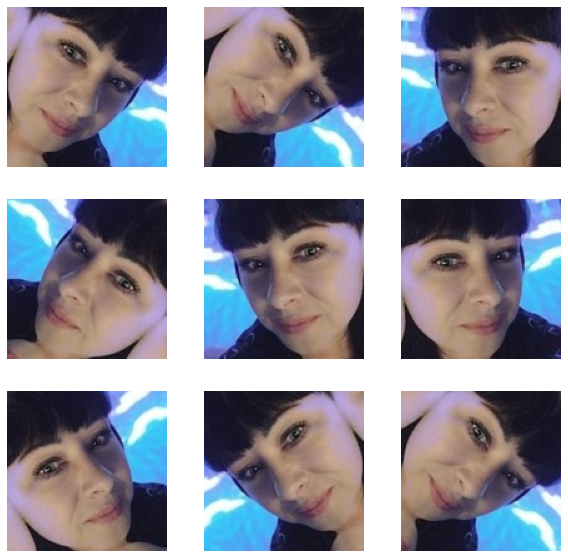

In [91]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Load pre-trained MobileNetV2 (trained on ImageNet)

In [92]:
base_model.trainable = False

### Train model

In [23]:
bucket_destination_dir = pathlib.Path("./train_buckets") 

training_folder = bucket_destination_dir

BATCH_SIZE = 32
IMG_SIZE = (128, 128)

train_images = None
validation_images = None

def get_train_data():
    train_images = tf.keras.preprocessing.image.ImageDataGenerator(
                                horizontal_flip=True,
                                vertical_flip=True,
                                rescale=1. / 255,
                                validation_split=0.2,
                                shear_range=0.1,
                                zoom_range=0.1,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                rotation_range=30,
                               ).flow_from_directory(directory=training_folder,
                                                     target_size=(128, 128),
                                                     subset='training',
                                                    )
    
    return train_images

def get_validation_data():
    validation_images = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1 / 255,
                                validation_split=0.2,
                               ).flow_from_directory(directory=training_folder,
                                                     target_size=(128, 128),
                                                     subset='validation',
                                                    ),
    return validation_images

In [24]:
tf.keras.backend.set_image_data_format('channels_last')

inc_model = tf.keras.applications.inception_v3.InceptionV3(
                        weights=None,
                        include_top=False,
                        input_shape=(128, 128, 3))

inc_model.load_weights('./inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5')

inc_model.trainable = False

# Adding some more layers at the end of the Model as per our requirement
model = tf.keras.models.Sequential([
    inc_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax') # 5 Output Neurons for 5 Classes
])

In [25]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_7 (Dense)             (None, 5)                 5125      
                                                                 
Total params: 23,906,085
Trainable params: 2,103,301
Non-trainable params: 21,802,784
__________________________________

In [8]:
!pip install pydot

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow2_p38/bin/python -m pip install --upgrade pip' command.


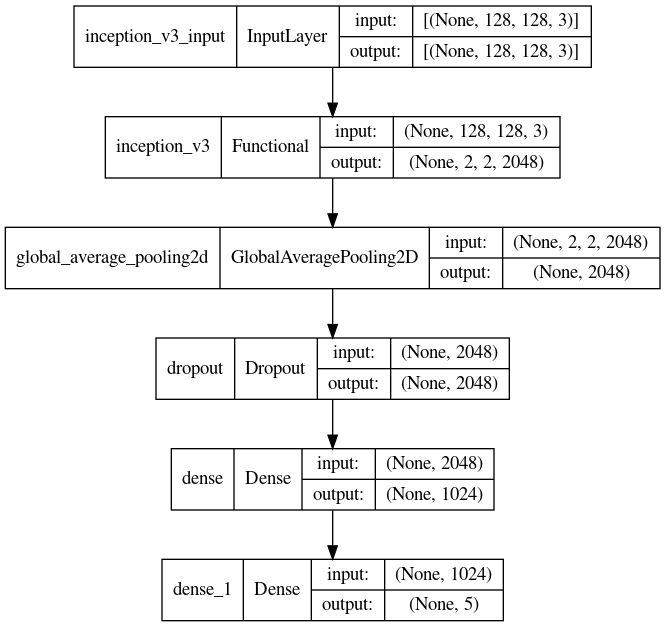

In [7]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

In [29]:
history = model.fit(get_train_data(), validation_data=get_validation_data(), epochs=5)

Found 39449 images belonging to 5 classes.
Found 9859 images belonging to 5 classes.
Epoch 1/5
1233/1233 [==============================] - 918s 745ms/step - loss: 1.3298 - accuracy: 0.4014 - val_loss: 1.3264 - val_accuracy: 0.4116
Epoch 2/5
1233/1233 [==============================] - 922s 748ms/step - loss: 1.3234 - accuracy: 0.4044 - val_loss: 1.3202 - val_accuracy: 0.4156
Epoch 3/5
1233/1233 [==============================] - 921s 747ms/step - loss: 1.3221 - accuracy: 0.4054 - val_loss: 1.3289 - val_accuracy: 0.4082
Epoch 4/5
1233/1233 [==============================] - 920s 747ms/step - loss: 1.3195 - accuracy: 0.4087 - val_loss: 1.3207 - val_accuracy: 0.4148
Epoch 5/5
1233/1233 [==============================] - 921s 747ms/step - loss: 1.3170 - accuracy: 0.4082 - val_loss: 1.3102 - val_accuracy: 0.4208


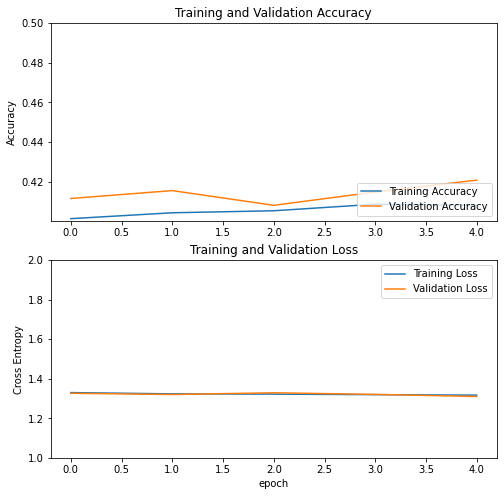

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),0.5])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([1,2])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()